In [ ]:
"""
Temporary train script for quick-start training
"""
%load_ext autoreload
%autoreload 2

import os
from typing import Callable, Mapping

from mujoco_playground._src import mjx_env, wrapper
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # visible GPU masks
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

import functools
import json
from datetime import datetime

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo

from IPython.display import clear_output, display


from vnl_mjx.tasks.rodent import head_track_rear

from omegaconf import OmegaConf

from tqdm import tqdm


from track_mjx.agent import checkpointing
from track_mjx.agent import wandb_logging
from track_mjx.agent.mlp_ppo import ppo_networks as track_networks

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

class FlattenObsWrapper(wrapper.Wrapper):

    def __init__(self, env: wrapper.mjx_env.MjxEnv):
        super().__init__(env)

    def reset(self, rng: jax.Array) -> wrapper.mjx_env.State:
        state = self.env.reset(rng)
        return self._flatten(state)

    def step(
        self, state: wrapper.mjx_env.State, action: jax.Array
    ) -> wrapper.mjx_env.State:
        state = self.env.step(state, action)
        return self._flatten(state)

    def _flatten(self, state: wrapper.mjx_env.State) -> wrapper.mjx_env.State:
        state = state.replace(
            obs=jax.flatten_util.ravel_pytree(state.obs)[0],
            metrics=self._flatten_metrics(state.metrics),
        )
        return state

    def _flatten_metrics(self, metrics: dict) -> dict:
        new_metrics = {}

        def rec(d: dict, prefix=""):
            for k, v in d.items():
                if isinstance(v, dict):
                    rec(v, prefix + k + "/")
                else:
                    new_metrics[prefix + k] = v

        rec(metrics)
        return new_metrics

    @property
    def observation_size(self) -> mjx_env.ObservationSize:
        abstract_state = jax.eval_shape(self.reset, jax.random.PRNGKey(0))
        obs = abstract_state.obs
        if isinstance(obs, Mapping):
            return jax.tree_util.tree_map(lambda x: x.shape, obs)
        return jp.sum(jax.flatten_util.ravel_pytree(obs.shape[-1])[0])

class HighLevelWrapper(wrapper.Wrapper):
    """Takes a decoder inference function and uses it to get the ctrl used in the sim step.

    The environment wrapped in this must use the same set of proprioceptive obs as the decoder.
    """

    def __init__(
        self,
        env: wrapper.mjx_env.MjxEnv,
        decoder_inference_fn: Callable,
        latent_size: int,
        non_proprioceptive_obs_size: int,
    ):
        self._decoder_inference_fn = decoder_inference_fn
        self._latent_size = latent_size
        self.non_proprioceptive_obs_size = non_proprioceptive_obs_size
        super().__init__(env)

    def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
        obs = state.obs

        # Note: We assume the non proprioceptive obs are first indices in obs, followed by proprioceptive obs.
        ctrl, _ = self._decoder_inference_fn(
            jp.concatenate(
                [action, obs[..., self.non_proprioceptive_obs_size :]],
                axis=-1,
            ),
        )
        return self.env.step(state, ctrl)

    @property
    def action_size(self) -> int:
        return self._latent_size
    
env_cfg = head_track_rear.default_config()

In [2]:
mimic_checkpoint_path = (
    "/n/holylabs-olveczky/Users/charleszhang/track-mjx/model_checkpoints/250913_162327_167947"
)
mimic_cfg = OmegaConf.create(
    checkpointing.load_config_from_checkpoint(mimic_checkpoint_path)
)

In [3]:
decoder_policy_fn = track_networks.make_decoder_policy_fn(mimic_checkpoint_path)


In [4]:
env_cfg.reward_terms["head_z_dist"]["weight"] = 0.0
env_cfg.reward_terms["torso_z_range"]["weight"] = 0.0

env = head_track_rear.HeadTrackRear(config=env_cfg)
env = HighLevelWrapper(
    FlattenObsWrapper(env), 
    decoder_policy_fn, 
    mimic_cfg.network_config.intention_size,
    0, # the head track task has no non-proprioceptive obs
)


In [5]:
reset = jax.jit(env.reset)
step = jax.jit(env.step)

To test that the hold_head_z reward is working correctly, I will manually raise qpos[2] by 0.15 - env._get_head_xpos()[2] (when the threshold is 0.12) and see if i get exactly 1 reward from that (after setting the head_z_dist weight to 0.0)

If that works, then the next thing is to test if i can continue to get reward if i do that multiple times (set it lower, then higher again for 50 steps (1 second))

In [6]:
from mujoco import mjx
forward = jax.jit(mjx.forward)

@jax.jit
def fix_qpos_z(state):
    new_qpos = state.data.qpos.at[2].set(state.data.qpos[2] + jp.abs(0.2 - env._get_head_xpos(state.data)[2]))
    # also maintain the quaternion
    new_qpos = new_qpos.at[3:7].set(jp.array([1,0,0,0]))
    # also maintain joint angles as zero
    new_qpos = new_qpos.at[7:].set(jp.zeros(env._mjx_model.nq - 7))
    new_data = forward(env._mjx_model, state.data.replace(qpos=new_qpos))
    return state.replace(data=new_data)

In [7]:
print(f"Setting initial qpos to get head above z threshold")
state = reset(rng=jax.random.PRNGKey(0))
states = [fix_qpos_z(state)]
print(f"Starting physics steps")
for i in tqdm(range(200)):
    state = step(state, jp.zeros(env.action_size))
    # print(f"before fix: {env._get_head_xpos(state.data)[2]}")
    state = fix_qpos_z(state)
    # print(f"after fix: {env._get_head_xpos(state.data)[2]}")
    states.append(state)


Setting initial qpos to get head above z threshold
Starting physics steps


100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


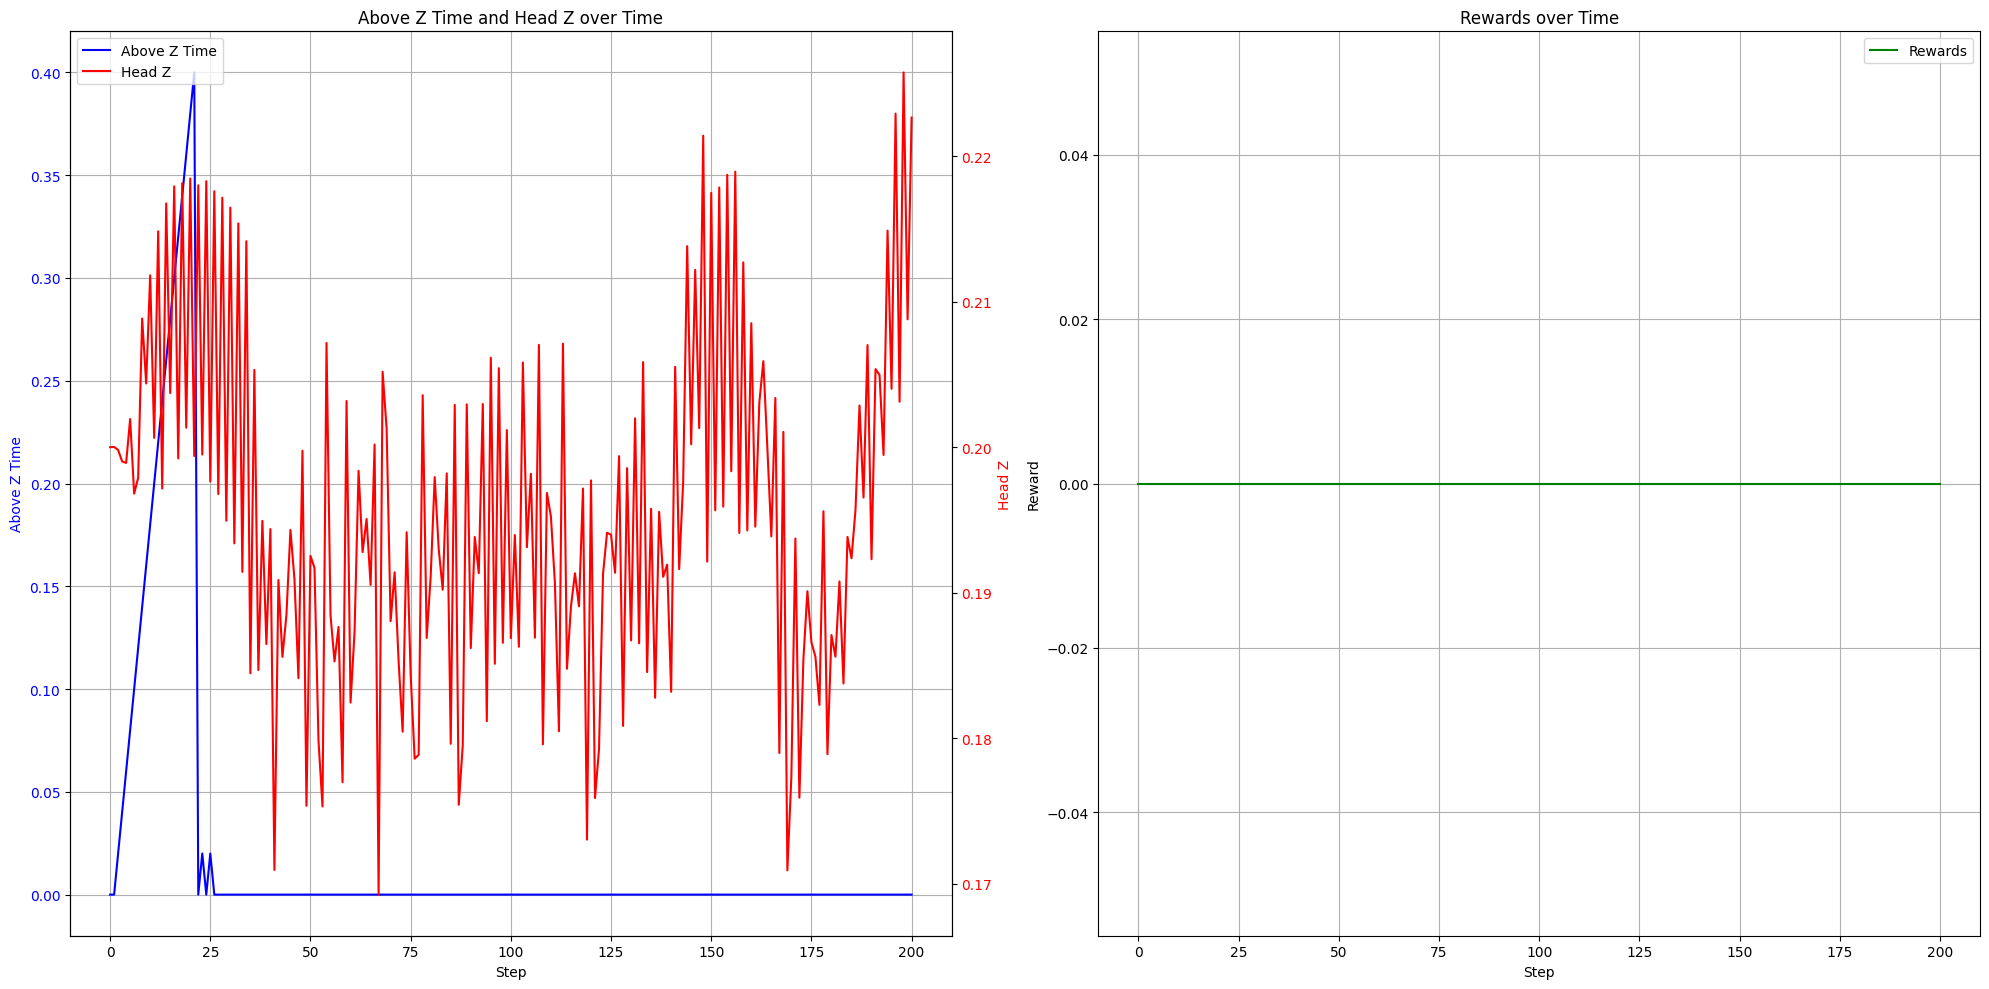

In [8]:
import matplotlib.pyplot as plt

rewards = [state.reward for state in states]
above_z_time = [state.info["above_z_time"] for state in states]
head_z = [env._get_head_xpos(state.data)[2] for state in states]

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20, 10))

# Left subplot: Above Z Time and Head Z
ax1.plot(above_z_time, 'b-', label='Above Z Time')
ax1.set_xlabel('Step')
ax1.set_ylabel('Above Z Time', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create second y-axis for head_z
ax2 = ax1.twinx()
ax2.plot(head_z, 'r-', label='Head Z')
ax2.set_ylabel('Head Z', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend for left subplot
ax1.set_title('Above Z Time and Head Z over Time')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Right subplot: Rewards over time
ax3.plot(rewards, 'g-', label='Rewards')
ax3.set_xlabel('Step')
ax3.set_ylabel('Reward')
ax3.set_title('Rewards over Time')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

In [9]:
import imageio

mj_model = env._mj_model
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
qposes_rollout = [state.data.qpos for state in states]
with imageio.get_writer("test_rollout.mp4", fps=int((1.0 / env.dt))) as video:
    for qpos in qposes_rollout:
        mj_data.qpos = qpos
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(
            mj_data,
            camera="close_profile-rodent",
        )
        video.append_data(renderer.render())
        

from IPython.display import Video, display

# Display the video
display(Video("test_rollout.mp4", width=512, height=512))



/n/holylabs-olveczky/Users/charleszhang/conda/mimic-mjx4/lib/python3.12/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/n/holylabs-olveczky/Users/charleszhang/conda/mimic-mjx4/lib/python3.12/site-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


FatalError: gladLoadGL error